# Импортируем библиотеки

In [1]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm


EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6'

In [2]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0,3,1,2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

In [3]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


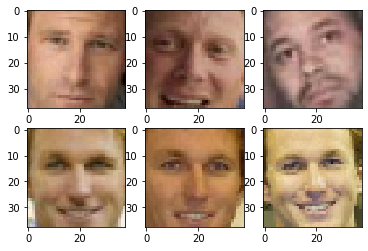

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Построим автоэнкодер как end2end сеть, в которой изображение подается на вход, проходит через боттлнэк и восстанавливается на выходе

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## Первый шаг: PCA

Principial Component Analysis - популярный метод понижения размерности.

PCA раскладывает матрицу $X$ на две матрицы меньшего размера $W$ and $\hat W$, минимизируя MSE:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - **центрированная** матрица;
- $W \in \mathbb{R}^{m \times d}$ - матрица прямого преобразования;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - матрица обратного преобразования;
- $n$ объектов, $m$ исходная размерность и $d$ размерность после сжатия;

Геометрически мы хотим найти d осей, вдоль которых мы имеем наибольшую дисперсию.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)

PCA можно рассмотреть как отдельный случай автоэнкодера.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Где Dense - это полносвязный слой без нелинейной функции активации:   $f(X) = W \cdot X + \vec b $

Заметим: bias в линейных слоях ответственен за центрирование матрицы, т.е. за вычитание среднего.

In [5]:
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape)

In [6]:
class pca_autoencoder(nn.Module):
    
    def __init__(self, code_size=32):
        super(pca_autoencoder, self).__init__()
        self.enc = torch.nn.Sequential(View(-1, 3*38*38), torch.nn.Linear(3*38*38, code_size))
        self.dec = torch.nn.Sequential(torch.nn.Linear(code_size, 3*38*38), View(-1, 3, 38, 38))
    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction)**2)

### Обучаем модель

In [7]:
def train(model, dataset, num_epoch=32):
    model.double()
    model.to(device)
    model.train()
    gd = optim.Adam(model.parameters(), lr=1e-3)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    losses = []
    for epoch in range(num_epoch):
        for batch in tqdm(dataloader):
            gd.zero_grad()
            loss = model.batch_loss(batch.cuda())
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            gd.step()
            gd.zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)
    model.eval()

In [8]:
def visualize(img, model):
    """Отобразим исходное изображение, код и реконструированное"""
    code = model.enc(img[None].cuda())
    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()

In [9]:
aenc = pca_autoencoder()
aenc_path = './pretrained_models/aenc.pth'
try:
    aenc.load_state_dict(torch.load(aenc_path))
    aenc.to(device)
    aenc.double()
except FileNotFoundError:
    train(aenc, X_train_tensor, num_epoch=50)
    torch.save(aenc.state_dict(), aenc_path)
aenc.eval()

pca_autoencoder(
  (enc): Sequential(
    (0): View()
    (1): Linear(in_features=4332, out_features=32, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=32, out_features=4332, bias=True)
    (1): View()
  )
)

In [10]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc.batch_loss(batch.cuda()).data.cpu().numpy())
print(np.mean(scores))

0.007540528248584305


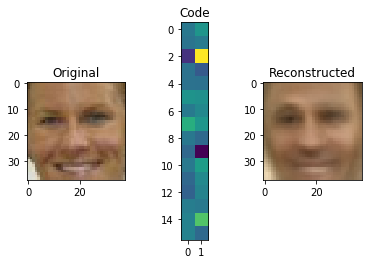

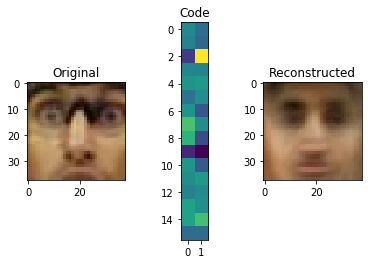

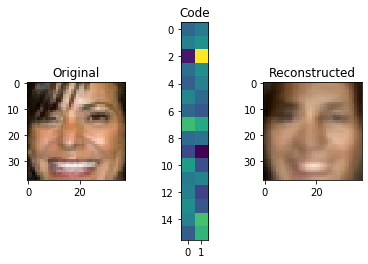

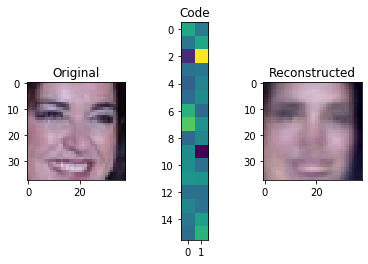

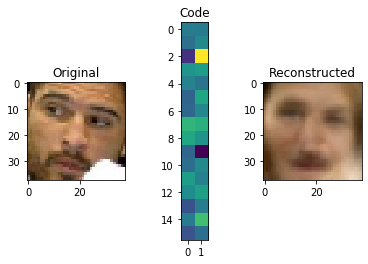

In [11]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)

### Going deeper

PCA работает, но, конечно, мы можем сделать лучше. На этот раз мы хотим многослойный автоэнкодер.

В частности, энкодер и декодер должны иметь глубину не менее 3-х слоев каждый.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

Примечание:
* Не должно быть скрытых слоев уже, чем боттлнэк (выход энкодера).
* Не забываем вставить нелинейности между слоями.
* В случае картинок хорошая идея - использовать сверточные слои.

In [12]:
class pca_autoencoder_deep(nn.Module):
    def __init__(self, code_size=32):
        super(pca_autoencoder_deep, self).__init__()
        self.enc = torch.nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), # b, 32, 19, 19
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False), # b, 64, 10, 10
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False), # b, 128, 5, 5
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            View(-1, 128*5*5),
            nn.Linear(128*5*5, code_size),
        )
        self.dec = torch.nn.Sequential(
            nn.Linear(code_size, 64*5*5),
            View(-1, 64, 5, 5),
            
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # b, 32, 10, 10
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # b, 16, 20, 20
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='bilinear'), # b, 16, 40, 40
            
            nn.Conv2d(16, 3, 3),  # b, 3, 38, 38
            nn.Sigmoid()
        )
    
    def batch_loss(self, batch, denoised_batch=None):
        reconstruction = self.dec(self.enc(batch))
        if denoised_batch is None:
            return torch.mean((batch - reconstruction)**2)
        else:
            return torch.mean((denoised_batch - reconstruction)**2)

In [13]:
aenc_deep = pca_autoencoder_deep()
aenc_deep_path = './pretrained_models/aenc_deep.pth'

try:
    aenc_deep.load_state_dict(torch.load(aenc_deep_path))
    aenc_deep.to(device)
    aenc_deep.double()
except FileNotFoundError:
    train(aenc_deep, X_train_tensor, 100)
    torch.save(aenc_deep.state_dict(), aenc_deep_path)
aenc_deep.eval()

pca_autoencoder_deep(
  (enc): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): View()
    (9): Linear(in_features=3200, out_features=32, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=32, out_features=1600, bias=True)
    (1): View()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Upsam

** Теперь проверим модель.**

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Final MSE: 0.006265689374312329


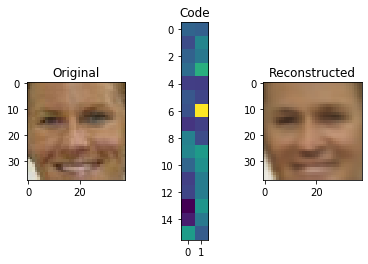

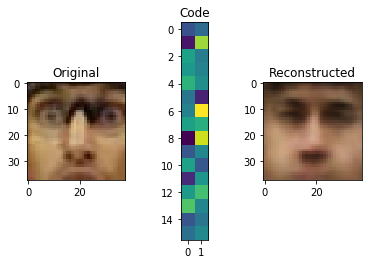

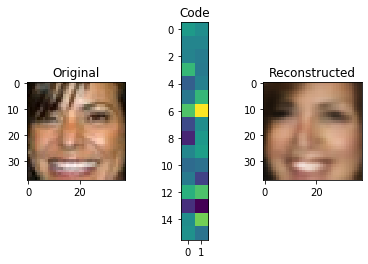

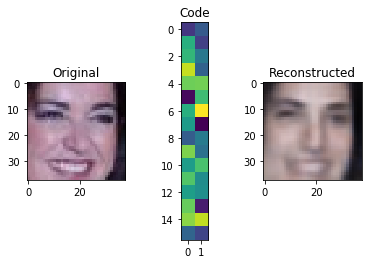

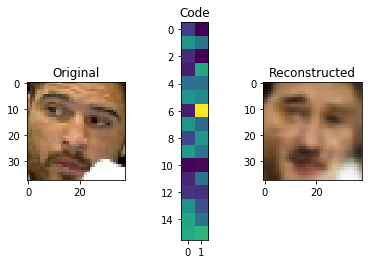

In [14]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc_deep.batch_loss(batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch.cuda(device = device))
reconstruction_mse  = np.mean(scores)

assert len(encoder_out.shape)==2 and encoder_out.shape[1]==32
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

## Denoising AutoEncoder

Теперь превратим модель в denoising autoencoder.

Оставим архитектуру прежней, но поменяем процедуру обучения. В частности, будет добавлять гауссовский шум к данным на каждой эпохе.

In [15]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    noise = np.random.randn(*X.shape) * sigma 
    return X + noise

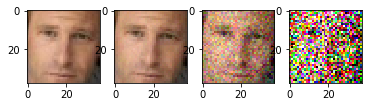

In [16]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0].transpose([1,2,0]).clip(0, 1))
plt.show()

In [17]:
def train_noise(model, dataset, num_epoch=50):
    model.double()
    model.to(device)
    gd = optim.Adam(model.parameters(), lr=1e-3)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in range(num_epoch):
        for i, (batch) in enumerate(dataloader):
            gd.zero_grad()
            loss = model.batch_loss(apply_gaussian_noise(batch).cuda(), batch)
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            gd.step()
            gd.zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

In [18]:
X_train_noise = apply_gaussian_noise(X_train)
X_test_noise = apply_gaussian_noise(X_test)

In [19]:
X_train_tensor_n = torch.from_numpy(X_train_noise).type(torch.DoubleTensor)
X_test_tensor_n = torch.Tensor(X_test_noise).type(torch.DoubleTensor)

In [20]:
aenc_deep_denoised = pca_autoencoder_deep()
aenc_deep_denoised_path = './pretrained_models/aenc_deep_denoised.pth'

try:
    aenc_deep_denoised.load_state_dict(torch.load(aenc_deep_denoised_path))
    aenc_deep_denoised.to(device)
    aenc_deep_denoised.double()
except FileNotFoundError:
    train(aenc_deep_denoised, X_train_tensor, 100)
    torch.save(aenc_deep_denoised.state_dict(), aenc_deep_denoised_path)
aenc_deep_denoised.eval()

pca_autoencoder_deep(
  (enc): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): View()
    (9): Linear(in_features=3200, out_features=32, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=32, out_features=1600, bias=True)
    (1): View()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Upsam

** Теперь проверим модель.**

Final MSE: 0.016435826486573865


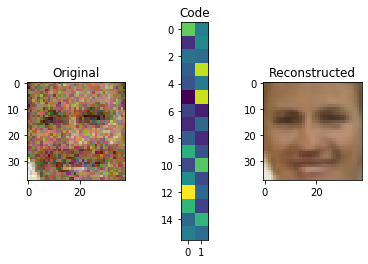

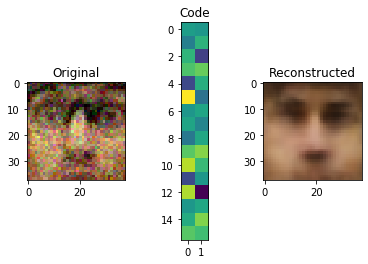

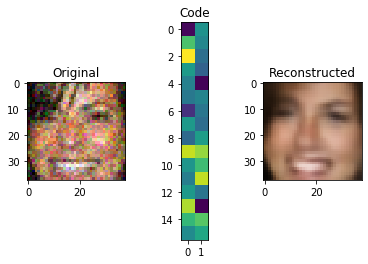

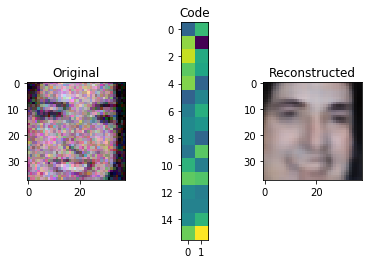

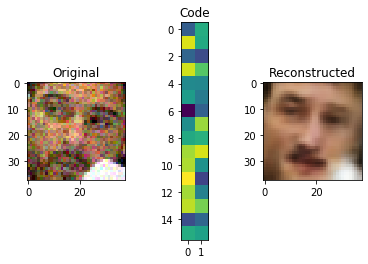

In [21]:
dataloader_test = DataLoader(X_test_tensor_n, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc_deep_denoised.batch_loss(batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc_deep_denoised.enc(batch.cuda(device = device))
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor_n[i]
    visualize(img,aenc_deep_denoised)

### Image retrieval with autoencoders

Итак, мы только что обучили сеть, которая из изображения получает обратно то же самое изображение. Эта задача не так уж полезна сама по себе, но имеет ряд удивительных приложений. Давайте посмотрим на это в действии.

Первое, что мы можем сделать, это поиск изображений (image retrieval). Мы берем изображение и находим похожие изображения в латентном пространстве.

Чтобы ускорить процесс поиска, воспользуемся алгоритмам поиска ближайших соседей из коробки, а именно из scikit-learn.

In [22]:
# Кодируем изображения
codes = aenc_deep_denoised.enc(X_train_tensor.to(device))

In [23]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [24]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors().fit(codes.detach().cpu().numpy())

In [25]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [26]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape)==3,"image must be [batch,height,width,3]"

    code = aenc_deep_denoised.enc(image[None].cuda(device)).detach().cpu().numpy()
    
    (distances,),(idx,) = nn.kneighbors(code, n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [27]:
def show_similar(image):
    
    distances,neighbors = get_similar(image, n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

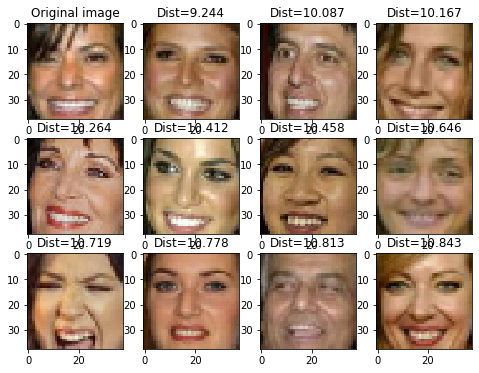

In [28]:
#smiles
show_similar(X_test_tensor[2])

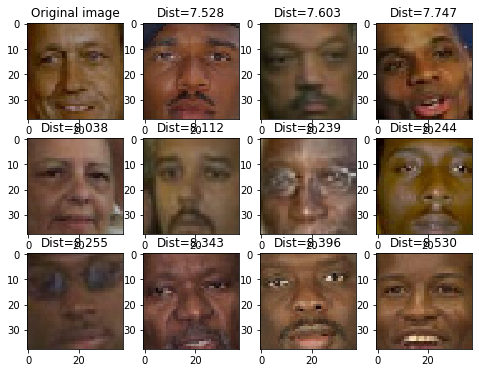

In [29]:
#ethnicity
show_similar(X_test_tensor[500])

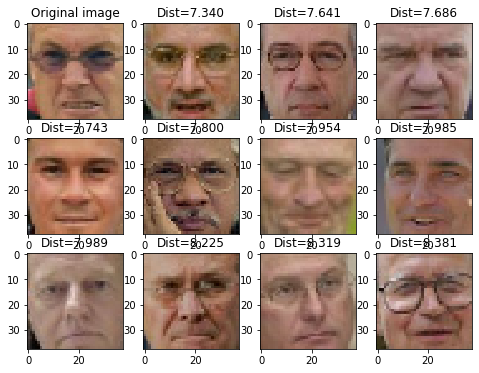

In [30]:
#glasses
show_similar(X_test_tensor[66])

## Cheap image morphing


Также мы можем взять два изображения, закодировать их и получить промежуточное, декодировав промежуточный код.

$$Code_{mixt} = a1\cdot code1 + a2\cdot code2$$

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


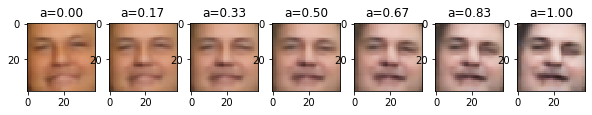

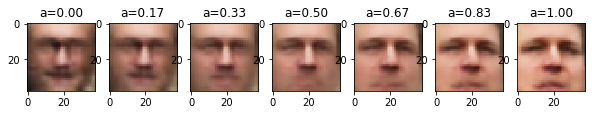

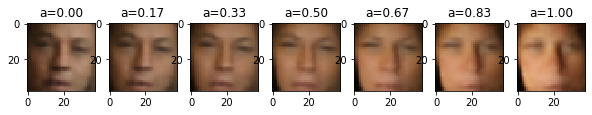

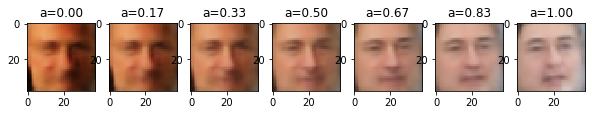

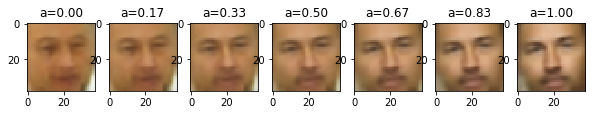

In [31]:
for _ in range(5):
    i1, i2 = np.random.randint(low=0, high=len(X_test_tensor), size=2)
    image1, image2 = X_test_tensor[i1], X_test_tensor[i2]

    code1, code2 = aenc_deep_denoised.enc(image1[None].cuda(device)), aenc_deep_denoised.enc(image2[None].cuda(device))


    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = a * code1 + (1.-a) * code2

        output_image = aenc_deep_denoised.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy().transpose([1,2,0]))
        plt.title("a=%.2f"%a)
        
    plt.show()